Loading the Datasets

(1000, 128, 256, 3) uint8
(1000, 128, 256) uint8


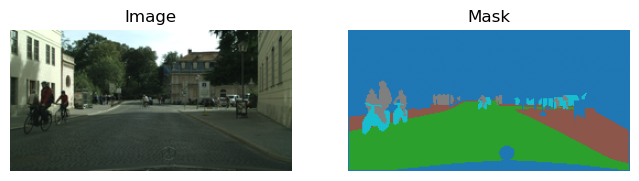

In [15]:
import numpy as np
import matplotlib.pyplot as plt

images = np.load('TestData/challenge_images.npy')   # (1000,128,256,3)
masks  = np.load('TestData/challenge_masks.npy')    # (1000,128,256)

print(images.shape, images.dtype)
print(masks.shape, masks.dtype)

# Visualize a sample
i = 998
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(images[i]); plt.axis('off'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(masks[i], cmap='tab10'); plt.axis('off'); plt.title('Mask')
plt.show()


Checking the training dataset - 


In [7]:
import numpy as np

unique, counts = np.unique(masks, return_counts=True)
class_dist = dict(zip(unique, counts))

print("Pixel counts per class ID:", class_dist)

# To check per-image presence
contains_pedestrian = [(m==3).any() for m in masks]
print("Images with pedestrians:", sum(contains_pedestrian))


Pixel counts per class ID: {np.uint8(0): np.int64(22831765), np.uint8(1): np.int64(6918391), np.uint8(2): np.int64(1122245), np.uint8(3): np.int64(231973), np.uint8(4): np.int64(1663626)}
Images with pedestrians: 549


From the above output we can observe the following interpretations - 
1. Class 0 (Background): ~22.8M pixels → dominates the dataset.

2. Class 1 (Road): ~6.9M pixels → strong presence, second largest.

3. Class 2 (Sidewalk): ~1.1M pixels → relatively small.

4. Class 3 (Pedestrian): ~0.23M pixels → very rare (~1% of total pixels).

5. Class 4 (Vehicle): ~1.6M pixels → small but significant.

Pedestrians appear in 549 images → so about half of your dataset has some pedestrians, but they occupy few pixels each time.

This confirms that the dataset is heavily imbalanced (background & road dominate, pedestrians are rare). And Hence, Data Augmentation must be used in order to increase the number of pedestrian datasets to improve the model's accuracy to track pedestrians. 

Model Design (CPU-friendly) - 

1. Use a small U-Net: fewer filters per layer (16–128 instead of 32–256).

2. Smaller batch size (2–4).

3. 15–20 epochs first (to get sanity results), then maybe extend if feasible.

Splitting the data into Train, Validation and Test sets - 

x_temp and y_temp are 30% of the data set which is split into x_val, y_val and x_test, y_test as 15% - 15%

In [17]:
from sklearn.model_selection import train_test_split

X = images
y = masks

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)


(700, 128, 256, 3) (150, 128, 256, 3) (150, 128, 256, 3)


Increasing images and mask pairs using Albumentations library

In [18]:
import albumentations as A

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.1),
])

def augment(image, mask):
    augmented = train_transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']


c:\Users\adilz\anaconda3\envs\bestfornumpy\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


UNet model selection

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def build_unet(input_shape=(128,256,3), n_classes=5):
    inputs = layers.Input(shape=input_shape)
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256)
    u3 = layers.UpSampling2D()(c4); u3 = layers.Concatenate()([u3, c3]); c5 = conv_block(u3, 128)
    u2 = layers.UpSampling2D()(c5); u2 = layers.Concatenate()([u2, c2]); c6 = conv_block(u2, 64)
    u1 = layers.UpSampling2D()(c6); u1 = layers.Concatenate()([u1, c1]); c7 = conv_block(u1, 32)
    outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c7)
    return Model(inputs, outputs)

model = build_unet()
model.summary()


C:\Users\adilz\AppData\Roaming\Python\Python312\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 128,   │          0 │ conv2d_9[0][0]  

 Total params: 1,947,013 (7.43 MB)

 Trainable params: 1,947,013 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

from the above printed table (of the U Net architecture) we can get the following insights:
1. Input: Images of size 128×256 pixels with 3 color channels (RGB)
2. Output: 128×256 pixels with 5 channels (likely representing 5 different classes for segmentation)
3. Total parameters: ~1.95 million trainable parameters

LOSS 

In [20]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    # y_true, y_pred shape: (B,H,W,C)
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))  # (B,HW,C)
    y_pred_f = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=1)
    dice = tf.reduce_mean((2. * intersection + smooth) / (denom + smooth), axis=-1)  # per-sample
    return tf.reduce_mean(dice)  # scalar

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred_f = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=1) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=-1)
    return tf.reduce_mean(iou)


In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coef, iou_score])
# Or use combined loss: loss = keras.losses.CategoricalCrossentropy() + 0.5*dice_loss


TRAINING THE MODEL - 

In [28]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
]

NUM_CLASSES = 5
BATCH_SIZE = 8

def preprocess(img, mask):
    img = tf.cast(img, tf.float32) / 255.0
    mask = tf.one_hot(tf.cast(mask, tf.int32), depth=NUM_CLASSES)
    return img, mask


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.map(lambda x,y: preprocess(x,y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: preprocess(x,y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=callbacks
)


88/88 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - dice_coef: 0.1976 - iou_score: 0.1430 - loss: 0.8713 - val_dice_coef: 0.2231 - val_iou_score: 0.1653 - val_loss: 0.7070 - learning_rate: 0.0010


Testing of the ML MODEL - 

In [29]:
import numpy as np

preds = model.predict(X_test / 255.0, batch_size=8)
preds_arg = np.argmax(preds, axis=-1)  # (N,H,W)

def per_class_iou(y_true, y_pred, n_classes=5):
    ious = []
    for c in range(n_classes):
        true_c = (y_true == c)
        pred_c = (y_pred == c)
        inter = np.logical_and(true_c, pred_c).sum()
        union = np.logical_or(true_c, pred_c).sum()
        iou = inter/(union+1e-6)
        ious.append(iou)
    return ious

ious = per_class_iou(y_test, preds_arg)
print('Per-class IoU:', ious)


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step
Per-class IoU: [np.float64(0.6738708496092378), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
